## Co-moving stars in Kepler

(done in a very hacky way) (but this is probably ok because we're assuming all the stars are far away)

In [1]:
import numpy as np
from astropy.table import Table, unique
from astropy import units as u
import astropy.coordinates as coord
from astropy.time import Time
from astropy.io import fits
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

Load up the table of all Gaia DR2 sources within the Kepler field:

In [2]:
gaia_table_file = '../data/16arcsec/gaia-kepler-dustin.fits'
hdul = fits.open(gaia_table_file)
gaia_src_tbl = Table(hdul[1].data)

In [3]:
#filter = (gaia_src_tbl['phot_g_mean_mag'] >= 18.) & (gaia_src_tbl['parallax'] > 0.01)
#gaia_src_tbl = gaia_src_tbl[filter]

In [4]:
gaia_src_tbl = gaia_src_tbl.to_pandas()

Now load up the Gaia-Kepler cross-match so we can add Kepler IDs to the best-match Gaia sources:

In [5]:
kepler_table_file = '../data/kepler_dr2_1arcsec.fits'
hdul = fits.open(kepler_table_file)
kepler_tbl = Table(hdul[1].data)
gaia_kepler_matches = kepler_tbl['kepid', 'kepler_gaia_ang_dist', 'source_id', 'nconfp', 'nkoi', 'planet?']
gaia_kepler_matches = gaia_kepler_matches.to_pandas()
print(len(gaia_kepler_matches))

195830


Trim off the less-good matches so that there's one unique Gaia source per Kepler target:

In [6]:
gaia_kepler_matches.sort_values(['kepid', 'kepler_gaia_ang_dist'], inplace=True)
gaia_kepler_matches.drop_duplicates('kepid', inplace=True)
print(len(gaia_kepler_matches))

193244


And join the tables:

In [7]:
table = gaia_src_tbl.merge(gaia_kepler_matches, on='source_id', how='left')
len(table)

9376693

In [8]:
test_id = 2105885485289168768
print(table[table['source_id'] == test_id])

                solution_id                   designation  \
979714  1635721458409799680  Gaia DR2 2105885485289168768   

                  source_id  random_index  ref_epoch          ra  ra_error  \
979714  2105885485289168768     486039161     2015.5  285.685012  0.018974   

              dec  dec_error  parallax   ...     radius_percentile_lower  \
979714  44.060521   0.020247  0.654823   ...                     1.27356   

        radius_percentile_upper  lum_val  lum_percentile_lower  \
979714                 1.658074   2.3351              2.141423   

        lum_percentile_upper      kepid  kepler_gaia_ang_dist  nconfp  nkoi  \
979714              2.528777  8151284.0              0.108671     0.0   0.0   

        planet?  
979714     none  

[1 rows x 99 columns]


Now load up Dustin's pairs:

In [9]:
pairs_file = '../data/16arcsec/matched-pairs-dustin.fits'
hdul = fits.open(pairs_file)
pairs = hdul[0].data

Define some useful functions:

In [ ]:
def make_x(table, table_ind):
    """
    returns a vector of x = [parallax, pmra, pmdec]
    """
    names = ['parallax', 'pmra', 'pmdec']
    return table.loc[table_ind, names].values

def make_xerr(table, table_ind):
    """
    returns a vector of xerr = [parallax_error, pmra_error, pmdec_error]
    """
    err_names = ['parallax_error', 'pmra_error', 'pmdec_error']
    return table.loc[table_ind, err_names].values    


In [10]:
def ppm_check(table, table_ind1, table_ind2, sigma=5.):
    """
    Returns True if the differences between parallax, pmra, and pmdec are all below 
    the sigma threshold.
    """
    x1 = make_x(table, table_ind1)
    x2 = make_x(table, table_ind2)
    if np.any(np.isnan([x1,x2])):
        return False
    xerr1 = make_xerr(table, table_ind1)
    xerr2 = make_xerr(table, table_ind2)
    if np.any(np.isnan([xerr1, xerr2])):
        return False
    if np.any(np.abs(x1 - x2)/np.sqrt(xerr1**2 + xerr2**2) >= sigma):
        return False
    return True

In [11]:
def make_cov(table, table_ind):
    """
    returns covariance matrix C corresponding to x
    """
    names = ['parallax', 'pmra', 'pmdec']
    C = np.diag(make_xerr(table, table_ind))
    for i, name1 in enumerate(names):
        for j, name2 in enumerate(names):
            if j >= i:
                continue
            corr = table.loc[table_ind, "{0}_{1}_corr".format(name2, name1)].values
            C[i, j] = corr * np.sqrt(C[i, i] * C[j, j])
            C[j, i] = C[i, j]
    return C

def chisq(table, table_ind1, table_ind2):
    """
    calculates chisquared for two stars based on their parallax and 2D proper motions
    """
    deltax = make_x(table, table_ind1) - make_x(table, table_ind2)
    cplusc = make_cov(table, table_ind1) + make_cov(table, table_ind1)
    return np.dot(deltax, np.linalg.solve(cplusc, deltax))

In [12]:
def calc_chisq(table, table_ind1, table_ind2):
    if ppm_check(table, table_ind1, table_ind2):
        return chisq(table, table_ind1, table_ind2)
    else:
        return -1

Now calculate a goodness-of-fit metric for each pair, skipping over the ones that don't make an initial cut:

In [ ]:
chisqs = np.zeros_like(pairs) - 1.

for i,row in tqdm(enumerate(pairs)):
    primary_ind = i
    match_inds = row[(row > -1) & (row > i)] # ignore non-matches and duplicates
    if len(match_inds) > 0:
        for j,match_ind in enumerate(match_inds):
            chisqs[i,j] = calc_chisq(table, primary_ind, match_ind)

18731810it [19:21:49, 268.71it/s]

Save the outputs and take a look at their distribution:

In [ ]:
hdu = fits.PrimaryHDU(chisqs)
hdulist = fits.HDUList([hdu])
hdulist.writeto('../data/chisqs_matched-pairs.fits')
hdulist.close()

In [13]:
# optional - load up already-saved outputs
hdul = fits.open('../data/16arcsec/chisqs_matched-pairs-dustin.fits')
chisqs = hdul[0].data

In [ ]:
plt.hist(chisqs[(chisqs > 0.) & (chisqs < 10.)], bins=100)
plt.xlabel('$\chi^2$', fontsize=16)
plt.ylabel('# Pairs', fontsize=16)
plt.yscale('log')
plt.savefig('chisq_keplerpairs.png')

OK, now let's select the best-fit pairs and save their indicies for easy access:

In [14]:
matches_mask = (chisqs > 0) & (chisqs < 2)
np.sum(matches_mask)

1112369

In [15]:
len_inds, len_matches = np.shape(pairs)
pairs_inds = np.array([np.arange(len_inds),]*len_matches).transpose()
pairs_ind1s = pairs_inds[matches_mask]
pairs_ind2s = pairs[matches_mask]

In [16]:
def read_match_attr(ind1, ind2, attr):
    return table.iloc[ind1][attr], table.iloc[ind2][attr]

In [17]:
print("source_ids of a pair:")
print(read_match_attr(pairs_ind1s[0], pairs_ind2s[0], 'source_id'))

source_ids of a pair:
(2097438792153786368, 2097438727722672128)


Sanity check: plot the parallax and proper motions of an identified match

In [18]:
from plot_tools import error_ellipse
fs = 12

In [19]:
def plot_xs(i, sigma=1):
    x1 = make_x(table.iloc[pairs_ind1s[i]])
    cov1 = make_cov(table.iloc[pairs_ind1s[i]])
    x2 = make_x(table.iloc[pairs_ind2s[i]])
    cov2 = make_cov(table.iloc[pairs_ind2s[i]])
    fig = plt.figure(figsize=(12,4))
    ax1 = fig.add_subplot(131)
    error_ellipse(ax1, x1[0], x1[1], cov1[:2,:2], ec='red', sigma=sigma)
    error_ellipse(ax1, x2[0], x2[1], cov2[:2,:2], ec='blue', sigma=sigma)
    ax1.set_xlim([min([x1[0], x2[0]]) - 5., max([x1[0], x2[0]]) + 5.])
    ax1.set_ylim([min([x1[1], x2[1]]) - 5., max([x1[1], x2[1]]) + 5.])
    ax1.set_xlabel('Parallax (mas)', fontsize=fs)
    ax1.set_ylabel('PM RA (mas yr$^{-1}$)', fontsize=fs)

    ax2 = fig.add_subplot(133)
    error_ellipse(ax2, x1[1], x1[2], cov1[1:,1:], ec='red', sigma=sigma)
    error_ellipse(ax2, x2[1], x2[2], cov2[1:,1:], ec='blue', sigma=sigma)
    ax2.set_xlim([min([x1[1], x2[1]]) - 5., max([x1[1], x2[1]]) + 5.])
    ax2.set_ylim([min([x1[2], x2[2]]) - 5., max([x1[2], x2[2]]) + 5.])
    ax2.set_xlabel('PM RA (mas yr$^{-1}$)', fontsize=fs)
    ax2.set_ylabel('PM Dec (mas yr$^{-1}$)', fontsize=fs)
    
    ax3 = fig.add_subplot(132)
    c1 = np.delete(np.delete(cov1, 1, axis=0), 1, axis=1)
    c2 = np.delete(np.delete(cov2, 1, axis=0), 1, axis=1)
    error_ellipse(ax3, x1[0], x1[2], c1, ec='red', sigma=sigma)
    error_ellipse(ax3, x2[0], x2[2], c2, ec='blue', sigma=sigma)
    ax3.set_xlim([min([x1[0], x2[0]]) - 5., max([x1[0], x2[0]]) + 5.])
    ax3.set_ylim([min([x1[2], x2[2]]) - 5., max([x1[2], x2[2]]) + 5.])
    ax3.set_xlabel('Parallax (mas)', fontsize=fs)
    ax3.set_ylabel('PM Dec (mas yr$^{-1}$)', fontsize=fs)
    
    fig.subplots_adjust(wspace = 0.5)
    fig.text(0.5, 0.95, 'match #{0}'.format(i), horizontalalignment='center', 
             transform=ax3.transAxes, fontsize=fs+2)

match 206275: source_ids (2128282979523450112, 2128282979524144768)


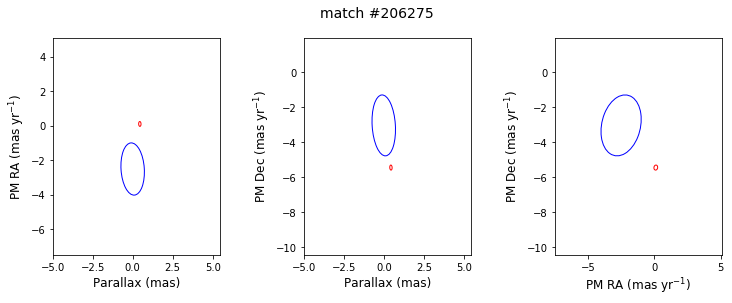

In [29]:
i = np.random.randint(0, len(pairs_ind1s))
print("match {0}: source_ids {1}".format(i, 
            read_match_attr(pairs_ind1s[i], pairs_ind2s[i], 'source_id')))
plot_xs(i, sigma=3)

In [57]:
pd.options.display.max_columns = None
src1, src2 = read_match_attr(pairs_ind1s[i], pairs_ind2s[i], 'source_id')
table[table['source_id'].isin([src1, src2])]

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,kepid,kepler_gaia_ang_dist,nconfp,nkoi,planet?
4044875,1635721458409799680,Gaia DR2 2128282979524144768,2128282979524144768,763947618,2015.5,293.057135,0.214137,46.615271,0.252514,-0.002099,0.244176,-0.008595,-2.514595,0.504772,-3.043395,0.579141,0.176803,0.010225,0.064297,0.013858,0.000909,0.013757,-0.225661,-0.115647,-0.138854,0.199341,188,0.0,188,0.0,1.437957,211.176956,0.585387,0.704396,31.0,false,0.211332,1.512166,0.063416,0.120206,22,17,0.535944,0,26,false,222,413.748322,1.272732,325.086761,19.146524,23,267.805939,11.786136,22.722116,19.281837,22,260.017334,7.837690,33.175251,18.724415,1.275711,0,0.557423,0.135313,0.422110,NaN,NaN,0,NaN,NaN,NaN,NOT_AVAILABLE,79.021560,12.894564,312.774067,66.662994,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4044881,1635721458409799680,Gaia DR2 2128282979523450112,2128282979523450112,609640258,2015.5,293.058745,0.021553,46.619354,0.025266,0.446509,0.024485,18.236210,0.098653,0.046861,-5.450016,0.047822,0.081148,-0.134729,-0.060617,0.014059,0.193158,0.003429,-0.377089,-0.051817,-0.085055,0.102158,176,176.0,176,0.0,-0.914012,154.025162,0.000000,0.000000,31.0,false,337.532837,1.516280,0.006121,0.218374,20,15,0.038348,0,24,false,210,243104.484375,38.886841,6251.587891,12.223884,24,106008.140625,157.050629,674.993408,12.788040,24,195005.640625,94.702888,2059.130859,11.536802,1.238207,0,1.251238,0.564157,0.687081,31.592958,1.332749,4,5000.0,3.0,-0.25,NOT_AVAILABLE,79.025821,12.895362,312.780688,66.666313,-31071,4842.162598,4711.810059,4972.0,0.097,0.0,0.9841,0.0223,0.0,0.1711,3503,10.55963,10.015329,11.151978,55.226768,50.008797,60.44474,9833831.0,0.059592,0.0,0.0,none


In [58]:
print("saved chisquared = {0:.5f}".format(chisqs[pairs_ind1s[i]][np.where(pairs[pairs_ind1s[i]] 
                                                                    == pairs_ind2s[i])[0][0]]))


saved chisquared = 0.28669


In [95]:
star1 = table[table['source_id'] == src1]
star2 = table[table['source_id'] == src2]
names = ['parallax', 'pmra', 'pmdec']
x1 = table.loc[pairs_ind1s[i], names].values
x2 = table.loc[pairs_ind2s[i], names].values
err_names = ['parallax_error', 'pmra_error', 'pmdec_error']
C = np.diag(table.loc[pairs_ind1s[i], err_names].values)
C
#x1 = np.array([star1[n].values[0] for n in names])
#x2 = np.array([star2[n].values[0] for n in names])
#chisq(star1, star2)

array([[0.024484733, 0, 0],
       [0, 0.046861395, 0],
       [0, 0, 0.047821548]], dtype=object)

Questionable matches to check on: 532830, 1065984 (no secondary??), 35263, 206275

Let's look at the relative luminosities of each match:

In [ ]:
(gmag1, gmag2) = read_match_attr(pairs_ind1s, pairs_ind2s, 'phot_g_mean_mag')
(plx1, plx2) = read_match_attr(pairs_ind1s, pairs_ind2s, 'parallax')
dist1 = 1.e3/plx1
absg1 = gmag1 - 5.*(np.log10(dist1) - 1.)
dist2 = 1.e3/plx2
absg2 = gmag2 - 5.*(np.log10(dist2) - 1.)

Select only the ones with measured G:

In [ ]:
mask = np.all(np.vstack([np.isfinite(absg1), np.isfinite(absg2)]), axis=0)
good_pairs_2d = np.vstack([absg1[mask], absg2[mask]])
#good_pairs_2d = np.sort(good_pairs_2d, axis=0) # we could sort by brightness here
absg1, absg2 = good_pairs_2d[0], good_pairs_2d[1]

In [ ]:
absg = np.append(absg1, absg2)
hist = plt.hist(absg, bins=500)
plt.xlim([-5,15])
plt.xlabel('G')
plt.ylabel('# of stars')
plt.savefig('absmag_hist.png')

In [ ]:
from matplotlib.colors import LogNorm
plt.hist2d(absg1, absg2, bins=(1000,1000), norm=LogNorm())
cbar = plt.colorbar()
cbar.ax.set_ylabel('# of stars', rotation=270)
plt.xlabel('G$_{1}$')
plt.ylabel('G$_{2}$')
plt.xlim([-5, 15])
plt.ylim([-5, 15])
plt.savefig('absmag_pairs.pdf')

Now let's see how many of the matches are in the Kepler catalog, and whether any of them have planets!

In [ ]:
ind1_is_kic = np.isfinite(table.iloc[pairs_ind1s]['kepid'])
ind2_is_kic = np.isfinite(table.iloc[pairs_ind2s]['kepid'])

In [ ]:
one_is_kic = np.any(np.vstack([ind1_is_kic, ind2_is_kic]), axis=0)
both_are_kic = np.all(np.vstack([ind1_is_kic, ind2_is_kic]), axis=0)

In [ ]:
np.sum(both_are_kic)

In [ ]:
for i1, i2 in zip(pairs_ind1s[both_are_kic], pairs_ind2s[both_are_kic]):
    print(read_match_attr(i1,i2,'planet?'))